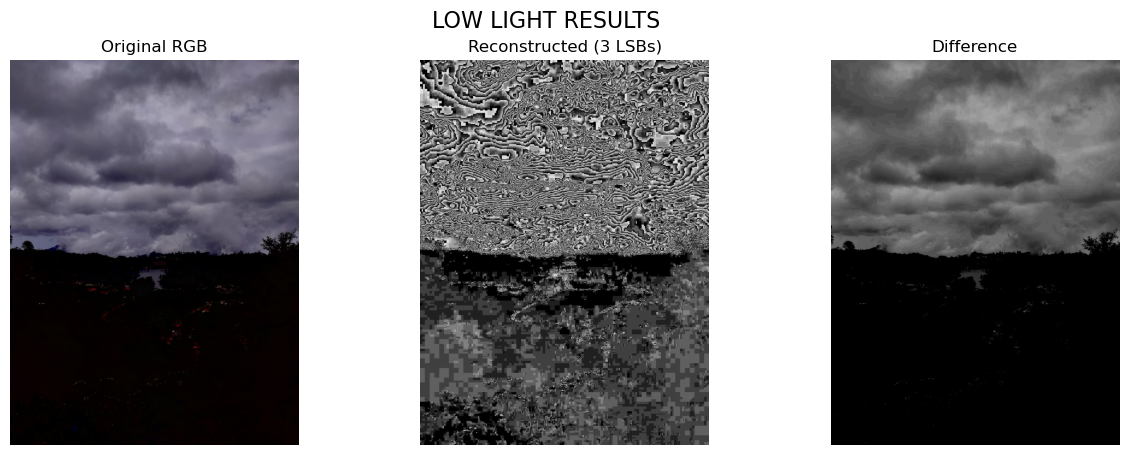

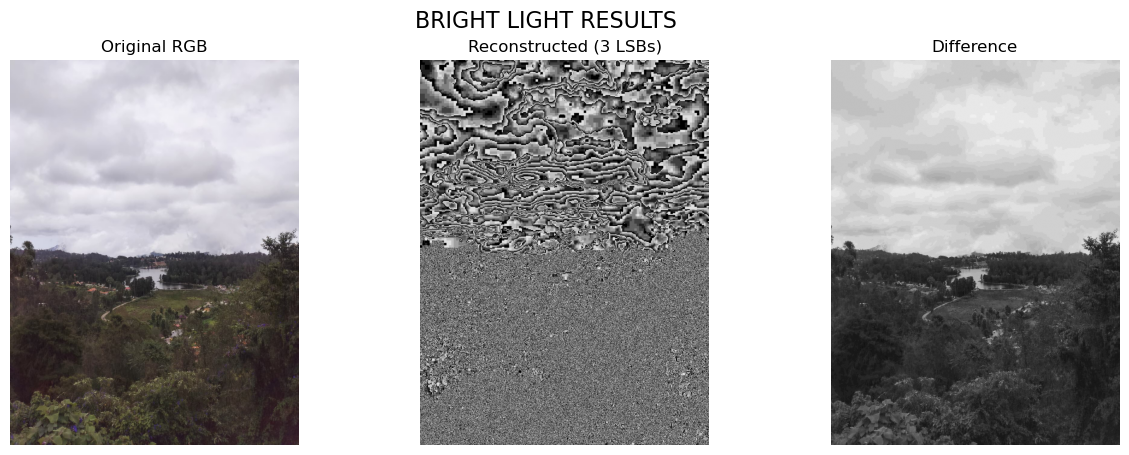

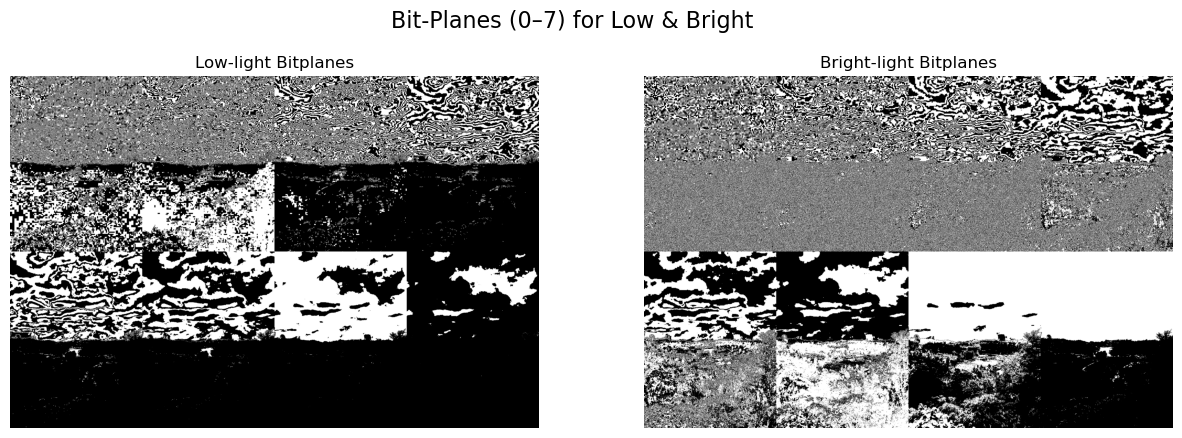

In [4]:
%matplotlib inline

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------
# ATTACHED FILE PATHS (You requested these exact paths)
# -----------------------------------------------------------

low_path = "D:/SEM 6/DIP/low.jpg"
bright_path = "D:/SEM 6/DIP/high.jpg"


# -----------------------------------------------------------
# Helper Functions
# -----------------------------------------------------------

def load_image_as_rgb_np(path):
    img = Image.open(path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    return arr


def compute_bitplanes_gray(img_gray):
    return [((img_gray >> k) & 1).astype(np.uint8) for k in range(8)]


def bitplanes_color(img_rgb):
    return [((img_rgb >> k) & 1).astype(np.uint8) for k in range(8)]


def reconstruct_from_lowest_3_bits_gray(img_gray):
    return (img_gray & 0b00000111).astype(np.uint8)


def reconstruct_from_lowest_3_bits_color(img_rgb):
    return (img_rgb & 0b00000111).astype(np.uint8)


def bitplanes_to_display_grid(bitplanes):
    planes = [(bp * 255).astype(np.uint8) for bp in bitplanes]
    cols = 4
    rows = int(np.ceil(len(planes) / cols))

    h, w = planes[0].shape
    grid = np.zeros((rows * h, cols * w), dtype=np.uint8)

    for i, p in enumerate(planes):
        r = i // cols
        c = i % cols
        grid[r*h:(r+1)*h, c*w:(c+1)*w] = p

    return grid


# -----------------------------------------------------------
# Processing
# -----------------------------------------------------------

def process_image_bitplanes(path, tag="image"):

    img_rgb = load_image_as_rgb_np(path)
    img_gray = np.dot(img_rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

    bp_gray = compute_bitplanes_gray(img_gray)
    bp_color = bitplanes_color(img_rgb)

    # Reconstruct using lowest 3 bit-planes
    recon_gray = reconstruct_from_lowest_3_bits_gray(img_gray)
    recon_color = reconstruct_from_lowest_3_bits_color(img_rgb)

    # Scale for visualization
    recon_gray_scaled = (recon_gray * 32).clip(0, 255).astype(np.uint8)
    recon_color_scaled = (recon_color * 32).clip(0, 255).astype(np.uint8)

    diff_gray = np.abs(img_gray.astype(int) - recon_gray.astype(int)).astype(np.uint8)
    diff_color = np.abs(img_rgb.astype(int) - recon_color.astype(int)).astype(np.uint8)

    # Prepare output folder
    save_folder = os.path.dirname(path)
    base = os.path.splitext(os.path.basename(path))[0]

    # Save outputs
    Image.fromarray(img_gray).save(os.path.join(save_folder, f"{base}_{tag}_gray.png"))
    Image.fromarray(recon_gray).save(os.path.join(save_folder, f"{base}_{tag}_recon_gray_3LSB.png"))
    Image.fromarray(recon_gray_scaled).save(os.path.join(save_folder, f"{base}_{tag}_recon_gray_3LSB_scaled.png"))
    Image.fromarray(diff_gray).save(os.path.join(save_folder, f"{base}_{tag}_diff_gray.png"))

    Image.fromarray(recon_color).save(os.path.join(save_folder, f"{base}_{tag}_recon_color_3LSB.png"))
    Image.fromarray(recon_color_scaled).save(os.path.join(save_folder, f"{base}_{tag}_recon_color_3LSB_scaled.png"))
    Image.fromarray(diff_color).save(os.path.join(save_folder, f"{base}_{tag}_diff_color.png"))

    # Bitplane grid
    grid = bitplanes_to_display_grid(bp_gray)
    Image.fromarray(grid).save(os.path.join(save_folder, f"{base}_{tag}_bitplanes.png"))

    return {
        "rgb": img_rgb,
        "gray": img_gray,
        "recon_gray_scaled": recon_gray_scaled,
        "diff_gray": diff_gray,
        "grid_gray": grid
    }


# -----------------------------------------------------------
# Run for both images
# -----------------------------------------------------------

low_res = process_image_bitplanes(low_path, tag="LOW")
bright_res = process_image_bitplanes(bright_path, tag="BRIGHT")


# -----------------------------------------------------------
# Display
# -----------------------------------------------------------

def show(title, imgs, labels):
    plt.figure(figsize=(15,5))
    plt.suptitle(title, fontsize=16)

    for i, (img, lbl) in enumerate(zip(imgs, labels), 1):
        plt.subplot(1, len(imgs), i)
        if img.ndim == 2:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img)
        plt.title(lbl)
        plt.axis('off')

    plt.show()


show("LOW LIGHT RESULTS",
     [low_res["rgb"], low_res["recon_gray_scaled"], low_res["diff_gray"]],
     ["Original RGB", "Reconstructed (3 LSBs)", "Difference"])

show("BRIGHT LIGHT RESULTS",
     [bright_res["rgb"], bright_res["recon_gray_scaled"], bright_res["diff_gray"]],
     ["Original RGB", "Reconstructed (3 LSBs)", "Difference"])


# Show bit-plane grid
show("Bit-Planes (0–7) for Low & Bright",
     [low_res["grid_gray"], bright_res["grid_gray"]],
     ["Low-light Bitplanes", "Bright-light Bitplanes"])